# Install dependencies

In [86]:
!pip uninstall sports -y
!pip install -q git+https://github.com/Gareth1995/sports.git

Found existing installation: sports 0.1.0
Uninstalling sports-0.1.0:
  Successfully uninstalled sports-0.1.0


In [1]:
import os
import math
import numpy as np
from inference import get_model
import pickle
import cv2
import supervision as sv
from tqdm import tqdm
from typing import List, Union
from collections import deque
from sports.common.team import TeamClassifier # this is pulling the model that separates players into teams (the code we done but a remote model)
from sports.common.view import ViewTransformer
from sports.configs.soccer import SoccerPitchConfiguration
from sports.configs.soccer import StatsbombSoccerPitchConfiguration

from sports.annotators.soccer import (
    draw_pitch,
    draw_points_on_pitch,
    draw_pitch_voronoi_diagram
)

[09/12/24 22:13:53] WARNING  Your inference package version 0.16.3 is out of date! Please upgrade to ]8;id=999197;file://c:\Users\GEdwards\miniconda3\envs\roboflow_env\lib\site-packages\inference\core\__init__.py\__init__.py]8;;\:]8;id=509171;file://c:\Users\GEdwards\miniconda3\envs\roboflow_env\lib\site-packages\inference\core\__init__.py#35\35]8;;\
                             version 0.18.1 of inference for the latest features and bug fixes by                  
                             running `pip install --upgrade inference`.                                            

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


In [2]:
# Video in use
# SOURCE_VIDEO_PATH = "data/arsenal_goal.mp4"
os.environ["ONNXRUNTIME_EXECUTION_PROVIDERS"] = "[CPUExecutionProvider]"
SOURCE_VIDEO_PATH = "data/ozil_goal_cut.mp4"

# Get Models

In [3]:
# Player Detection
PLAYER_DETECTION_MODEL_ID = "football-players-detection-3zvbc/11"
PLAYER_DETECTION_MODEL = get_model(model_id=PLAYER_DETECTION_MODEL_ID, api_key='g0kReC3ubPe9dTtlz7uN')

# Field detection
FIELD_DETECTION_MODEL_ID = "football-field-detection-f07vi/14"
FIELD_DETECTION_MODEL = get_model(model_id=FIELD_DETECTION_MODEL_ID, api_key='g0kReC3ubPe9dTtlz7uN')

# Build Team Classifier

In [90]:
os.environ["ONNXRUNTIME_EXECUTION_PROVIDERS"] = "[CPUExecutionProvider]"
# os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"  # provides a safe threaded environment for models used in team classifier (I think)

# Team classifier
PLAYER_ID = 2
STRIDE = 1 # use every frame in the video

frame_generator = sv.get_video_frames_generator(
    source_path=SOURCE_VIDEO_PATH, stride=STRIDE)

crops = []
for frame in tqdm(frame_generator, desc='collecting crops'):
    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)
    players_detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

team_classifier = TeamClassifier(device="cpu")
team_classifier.fit(crops)

collecting crops: 0it [00:00, ?it/s]

collecting crops: 390it [52:09,  8.02s/it]
Embedding extraction: 136it [1:04:30, 28.46s/it]


### Save classifier object

In [91]:
import pickle

# Save the team_classifier object to a file
with open('team_classifier.pkl', 'wb') as file:
    pickle.dump(team_classifier, file)

# Create Video Visualisation

The block below creates the visualisation with elipses around players and triangle over ball. The elipses should be coloured by team.

In [4]:
# Utility function to group the correct goalkeeper with the correct team

def resolve_goalkeepers_team_id(
    players: sv.Detections,
    goalkeepers: sv.Detections
) -> np.ndarray:
    goalkeepers_xy = goalkeepers.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    players_xy = players.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    team_0_centroid = players_xy[players.class_id == 0].mean(axis=0)
    team_1_centroid = players_xy[players.class_id == 1].mean(axis=0)
    goalkeepers_team_id = []
    for goalkeeper_xy in goalkeepers_xy:
        dist_0 = np.linalg.norm(goalkeeper_xy - team_0_centroid)
        dist_1 = np.linalg.norm(goalkeeper_xy - team_1_centroid)
        goalkeepers_team_id.append(0 if dist_0 < dist_1 else 1)

    return np.array(goalkeepers_team_id)

### Elipses visualisation

In [96]:
TARGET_VIDEO_PATH = 'data/ozil_goal_cut_viz.mp4'
# BALL_ID = 0

# ellipse_annotator = sv.EllipseAnnotator(
#     color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
#     thickness=2
# )
# triangle_annotator = sv.TriangleAnnotator(
#     color=sv.Color.from_hex('#FFD700'),
#     base=20, height=17
# )

# video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH) # info on the video
# video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info) # allows saving video to the hard drive

# frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
# frame = next(frame_generator)

# with video_sink:
#   for frame in tqdm(frame_generator, total=video_info.total_frames):

# result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
# detections = sv.Detections.from_inference(result)

# ball_detections = detections[detections.class_id == BALL_ID]
# ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

# all_detections = detections[detections.class_id != BALL_ID]
# all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True) # this function removes overlapping detections
# all_detections.class_id -= 1

# annotated_frame = frame.copy()
# annotated_frame = ellipse_annotator.annotate(
#     scene=annotated_frame,
#     detections=all_detections)
# annotated_frame = triangle_annotator.annotate(
#     scene=annotated_frame,
#     detections=ball_detections)

# sv.plot_image(annotated_frame)

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH) # info on the video
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info) # allows saving video to the hard drive

BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=20, height=17
)

tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
# frame = next(frame_generator)

with video_sink:
  for frame in tqdm(frame_generator, total=video_info.total_frames):
    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)

    ball_detections = detections[detections.class_id == BALL_ID]
    ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

    all_detections = detections[detections.class_id != BALL_ID]
    all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
    all_detections = tracker.update_with_detections(detections=all_detections)

    goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
    players_detections = all_detections[all_detections.class_id == PLAYER_ID]
    referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

    players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
    players_detections.class_id = team_classifier.predict(players_crops)

    goalkeepers_detections.class_id = resolve_goalkeepers_team_id(
        players_detections, goalkeepers_detections)

    referees_detections.class_id -= 1

    all_detections = sv.Detections.merge([
        players_detections, goalkeepers_detections, referees_detections])

    labels = [
        f"#{tracker_id}"
        for tracker_id
        in all_detections.tracker_id
    ]

    all_detections.class_id = all_detections.class_id.astype(int)

    annotated_frame = frame.copy()
    annotated_frame = ellipse_annotator.annotate(
        scene=annotated_frame,
        detections=all_detections)
    annotated_frame = label_annotator.annotate(
        scene=annotated_frame,
        detections=all_detections,
        labels=labels)
    annotated_frame = triangle_annotator.annotate(
        scene=annotated_frame,
        detections=ball_detections)

    # sv.plot_image(annotated_frame)

    video_sink.write_frame(annotated_frame) # write frame to the video sink that will recreate the video from each frame

  0%|          | 0/390 [00:00<?, ?it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:03,  3.67s/it]
  0%|          | 1/390 [00:08<53:09,  8.20s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:03,  3.32s/it]
  1%|          | 2/390 [00:16<53:34,  8.28s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:03,  3.44s/it]
  1%|          | 3/390 [00:24<52:39,  8.16s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:03,  3.47s/it]
  1%|          | 4/390 [00:32<52:03,  8.09s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:03,  3.81s/it]
  1%|▏         | 5/390 [00:40<52:07,  8.12s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:03,  3.89s/it]
  2%|▏         | 6/390 [00:49<53:43,  8.39s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:03,  3.35s/it]
  2%|▏         | 7/390 [00:57<52:14,  8.18s/it]
Embedding extraction: 

## Vornoi Visualisation

### Configure pitch parameters for pitch plots

In [5]:
# configure pitch
# CONFIG = SoccerPitchConfiguration()
CONFIG_statsbomb = StatsbombSoccerPitchConfiguration()

# annotated_frame = draw_pitch(CONFIG)
annotated_frame_statsbomb = draw_pitch(CONFIG_statsbomb)

In [6]:
# load variables if possible
with open('team_classifier.pkl', 'rb') as file:
    team_classifier = pickle.load(file)

In [ ]:
TARGET_VIDEO_PATH = "data/ozil_goal_cut_vornoi.mp4"

# everything put together
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=20, height=17
)

tracker = sv.ByteTrack()
tracker.reset()

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH) # info on the video
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info) # allows saving video to the hard drive
print(video_info)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# ball, goalkeeper, player, referee detection

with video_sink:
    # for frame in tqdm(frame_generator, total=video_info.total_frames):
    for i in range (50):
        frame = next(frame_generator)
        
        result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
        detections = sv.Detections.from_inference(result)

        ball_detections = detections[detections.class_id == BALL_ID]
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

        all_detections = detections[detections.class_id != BALL_ID]
        all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
        all_detections = tracker.update_with_detections(detections=all_detections)

        goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
        players_detections = all_detections[all_detections.class_id == PLAYER_ID]
        referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

        # team assignment

        players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
        players_detections.class_id = team_classifier.predict(players_crops)

        goalkeepers_detections.class_id = resolve_goalkeepers_team_id(
            players_detections, goalkeepers_detections)

        referees_detections.class_id -= 1

        all_detections = sv.Detections.merge([
            players_detections, goalkeepers_detections, referees_detections])

        # frame visualization

        labels = [
            f"#{tracker_id}"
            for tracker_id
            in all_detections.tracker_id
        ]

        all_detections.class_id = all_detections.class_id.astype(int)

        players_detections = sv.Detections.merge([
            players_detections, goalkeepers_detections
        ])

        # detect pitch key points

        result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
        key_points = sv.KeyPoints.from_inference(result)

        # project ball, players and referies on pitch

        if key_points:
            filter = key_points.confidence[0] > 0.5
            frame_reference_points = key_points.xy[0][filter]
            pitch_reference_points = np.array(CONFIG_statsbomb.vertices)[filter]

            # Here's where homography takes place (edit target to have statsbomb pitch measurements so that player xy and ball xy can be plotted using mplsoccer)
            if len(frame_reference_points) >= 4:
                transformer = ViewTransformer(
                    source=frame_reference_points,
                    target=pitch_reference_points
                )

                frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
                pitch_ball_xy = transformer.transform_points(points=frame_ball_xy)

                players_xy = players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
                pitch_players_xy = transformer.transform_points(points=players_xy)

                referees_xy = referees_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
                pitch_referees_xy = transformer.transform_points(points=referees_xy)

                if(len(pitch_players_xy) > 0):
                    annotated_frame = draw_pitch(CONFIG_statsbomb)
                    annotated_frame = draw_pitch_voronoi_diagram(
                        config=CONFIG_statsbomb,
                        team_1_xy=pitch_players_xy[players_detections.class_id == 0],
                        team_2_xy=pitch_players_xy[players_detections.class_id == 1],
                        team_1_color=sv.Color.from_hex('00BFFF'),
                        team_2_color=sv.Color.from_hex('FF1493'),
                        pitch=annotated_frame)

                    sv.plot_image(annotated_frame)
                    
                    # Overlay the annotated frame on the original frame
                    overlay_frame = cv2.addWeighted(frame, 0.5, annotated_frame, 0.5, 0)
                    video_sink.write_frame(annotated_frame)
               


In [31]:
# Arsenal xT
arsenal_xt = [[1.22864434e-04, 1.53993958e-04, 1.88009372e-04, 3.11256835e-04,
        3.14493153e-04, 7.98694421e-04, 9.48561772e-04, 1.47960812e-03,
        1.60628443e-03, 3.55071489e-03, 5.30780197e-03, 8.24114013e-03,
        1.22571532e-02, 1.49203810e-02, 2.25618316e-02, 5.75568624e-02],
       [1.60208555e-04, 2.22973611e-04, 2.74215429e-04, 2.92259591e-04,
        7.92376787e-04, 5.89032912e-04, 9.49792166e-04, 1.48894132e-03,
        2.09604140e-03, 3.78825366e-03, 6.30058463e-03, 1.13583943e-02,
        1.67213543e-02, 2.35711133e-02, 2.99616828e-02, 3.12241228e-02],
       [1.10509824e-04, 1.55682167e-04, 3.08499556e-04, 3.41954377e-04,
        4.97272686e-04, 4.04656900e-04, 8.32925803e-04, 1.44823427e-03,
        2.52731103e-03, 4.04042652e-03, 7.28963655e-03, 1.31047798e-02,
        2.11892617e-02, 3.07976702e-02, 3.67096255e-02, 5.31224238e-02],
       [2.52434745e-04, 3.96743578e-04, 3.57174052e-04, 6.08781458e-04,
        4.58288124e-04, 5.95962156e-04, 9.50331253e-04, 1.35563815e-03,
        2.52218242e-03, 5.25416716e-03, 9.62231548e-03, 1.56199743e-02,
        2.82696425e-02, 4.26779887e-02, 5.89590471e-02, 7.61236308e-02],
       [2.95620043e-04, 5.00603399e-04, 4.08426424e-04, 4.46400176e-04,
        5.37268611e-04, 6.42299030e-04, 8.63768416e-04, 1.35749832e-03,
        3.21378556e-03, 5.88574352e-03, 9.43646007e-03, 1.66930583e-02,
        3.10734162e-02, 5.28689705e-02, 1.10300519e-01, 9.02142363e-02],
       [1.44091553e-03, 7.31299698e-04, 7.54245442e-04, 6.63217281e-04,
        3.68710288e-04, 7.02390338e-04, 9.08720535e-04, 1.81499938e-03,
        3.01482711e-03, 6.20076052e-03, 1.08706187e-02, 1.98406420e-02,
        3.16844192e-02, 6.79409521e-02, 1.30817892e-01, 2.74726608e-01],
       [1.23408788e-03, 6.36822841e-04, 8.19224103e-04, 7.21919063e-04,
        6.73222780e-04, 8.02806622e-04, 9.79071538e-04, 1.95362751e-03,
        2.19530282e-03, 5.48466854e-03, 8.56065635e-03, 1.89171754e-02,
        3.12404361e-02, 7.10194006e-02, 1.31567816e-01, 2.30320859e-01],
       [3.26844900e-04, 8.25291698e-04, 5.58255994e-04, 1.10468806e-03,
        7.11442392e-04, 7.53899906e-04, 9.96535335e-04, 2.04110852e-03,
        2.59495111e-03, 4.36704139e-03, 1.05871520e-02, 1.79770150e-02,
        3.03319004e-02, 5.03855274e-02, 9.96748049e-02, 1.27389668e-01],
       [3.92589020e-04, 4.20312309e-04, 4.09510097e-04, 4.26253648e-04,
        6.40998887e-04, 5.24711437e-04, 1.01467953e-03, 1.48275746e-03,
        2.30628583e-03, 4.70130255e-03, 8.47648117e-03, 1.53804902e-02,
        2.41244939e-02, 3.68959914e-02, 6.33526619e-02, 8.19106659e-02],
       [3.40778009e-04, 1.49283852e-04, 2.26511968e-04, 4.14703956e-04,
        8.57042782e-04, 6.77407740e-04, 8.64968227e-04, 1.42843851e-03,
        2.98153127e-03, 5.16514730e-03, 7.88621801e-03, 1.29212804e-02,
        2.36352348e-02, 3.08831973e-02, 4.46774459e-02, 5.75023103e-02],
       [8.93928057e-05, 1.45005698e-04, 2.48160691e-04, 5.23278032e-04,
        7.10408440e-04, 8.07560105e-04, 7.89115258e-04, 1.47788474e-03,
        2.62153790e-03, 3.57960854e-03, 6.77805806e-03, 1.07538288e-02,
        1.94249470e-02, 2.79214571e-02, 3.52900813e-02, 4.57487134e-02],
       [1.04338017e-04, 1.78418334e-04, 2.07630295e-04, 2.25150810e-04,
        3.19538706e-04, 4.51240677e-04, 1.17245442e-03, 1.13654930e-03,
        1.81155062e-03, 3.50306679e-03, 5.09185106e-03, 9.34532163e-03,
        1.41230002e-02, 1.94168900e-02, 2.61659834e-02, 8.44230949e-02]]

# Ball Tracking

The blocks below calculate the xy coordinates of the soccer ball for each frame. Any non-detections or multiple ball detections are removed from the path list.

In [74]:
from sports.annotators.soccer import draw_pitch, draw_points_on_pitch

BALL_ID = 0
MAXLEN = 20 # number of frames to average over for ball xy coordinates (increase for a smoother tragectory)

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

path_raw = []
M = deque(maxlen=MAXLEN)

for frame in tqdm(frame_generator, total=video_info.total_frames):

    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)

    ball_detections = detections[detections.class_id == BALL_ID]
    ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

    result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    key_points = sv.KeyPoints.from_inference(result)

    if key_points:
        filter = key_points.confidence[0] > 0.5
        frame_reference_points = key_points.xy[0][filter]
        pitch_reference_points = np.array(CONFIG_statsbomb.vertices)[filter]
        
        if len(frame_reference_points) >= 4:
            transformer = ViewTransformer(
                source=frame_reference_points,
                target=pitch_reference_points
            )

            M.append(transformer.m)
            transformer.m = np.mean(np.array(M), axis=0)

        
            frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
            pitch_ball_xy = transformer.transform_points(points=frame_ball_xy)

            path_raw.append(pitch_ball_xy)
    

100%|██████████| 390/390 [23:48<00:00,  3.66s/it]


In [34]:
# np.save('raw_path', path_raw)

In [64]:
# path_raw = np.load('raw_path.npy', allow_pickle=True)
# path = [coorinates.flatten() for coorinates in path_raw]

In [75]:
# removing empty arrays
path = [
    np.empty((0, 2), dtype=np.float32) if coorinates.shape[0] >= 2 else coorinates
    for coorinates
    in path_raw
]

path = [coorinates.flatten() for coorinates in path]

In [76]:
# remove instances of multiple ball detections in a given frame
def replace_outliers_based_on_distance(
    positions: List[np.ndarray],
    distance_threshold: float
) -> List[np.ndarray]:
    last_valid_position: Union[np.ndarray, None] = None
    cleaned_positions: List[np.ndarray] = []

    for position in positions:
        if len(position) == 0:
            # If the current position is already empty, just add it to the cleaned positions
            cleaned_positions.append(position)
        else:
            if last_valid_position is None:
                # If there's no valid last position, accept the first valid one
                cleaned_positions.append(position)
                last_valid_position = position
            else:
                # Calculate the distance from the last valid position
                distance = np.linalg.norm(position - last_valid_position)
                if distance > distance_threshold:
                    # Replace with empty array if the distance exceeds the threshold
                    cleaned_positions.append(np.array([], dtype=np.float64))
                else:
                    cleaned_positions.append(position)
                    last_valid_position = position

    return cleaned_positions

In [77]:
MAX_DISTANCE_THRESHOLD = 1000

path = replace_outliers_based_on_distance(path, MAX_DISTANCE_THRESHOLD)

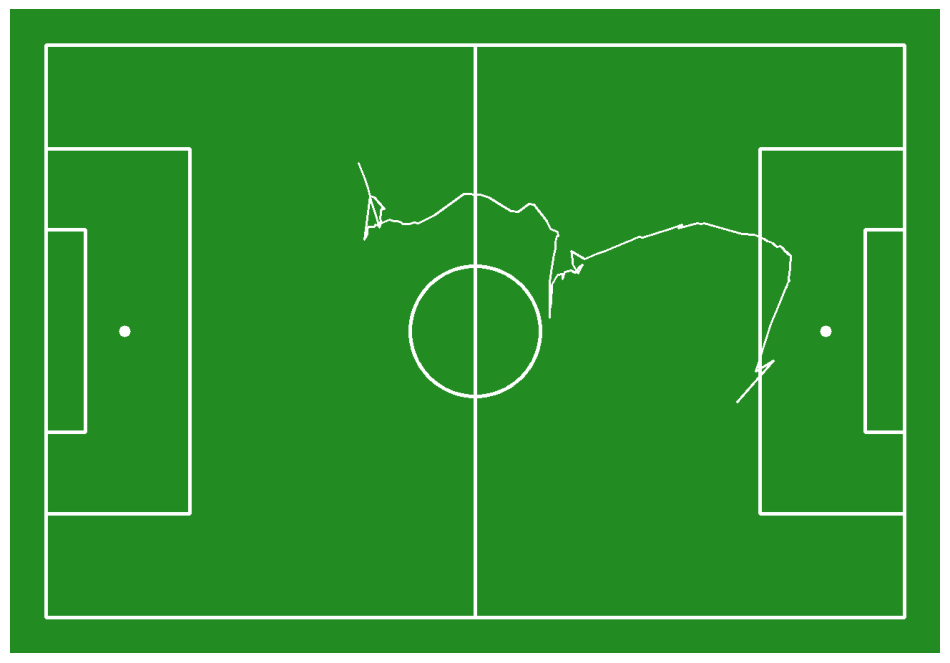

In [78]:
# Draw ball path on pitch
from sports.annotators.soccer import draw_paths_on_pitch


annotated_frame = draw_pitch(CONFIG_statsbomb)
annotated_frame = draw_paths_on_pitch(
    config=CONFIG_statsbomb,
    paths=[path],
    color=sv.Color.WHITE,
    pitch=annotated_frame)

sv.plot_image(annotated_frame)

# Calculate xT

The code below calculates xT per frame

In [57]:
# calculate xT value of ball location based on single frame
def xT_now(ball_coords, xT_grid):

    # convert this ball xy to a grid position in the binned statistic method in xT project
    sb_ball_x = math.floor(ball_coords[0] / 750)
    sb_ball_y = math.floor(ball_coords[1] / 666.67)

    xT = xT_grid[sb_ball_y][sb_ball_x]

    return xT


In [85]:
# create xT video plot
import matplotlib.pyplot as plt
import cv2

TARGET_VIDEO_PATH = 'data/live_xt.avi'
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH) # info on the video

# create target video for output
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(TARGET_VIDEO_PATH, fourcc, video_info.fps, (640, 480))

acc_xt = 0
xt_overtime = []

# with video_sink:
for c in path:
    if len(c) > 0:
        xt = xT_now([c[0], c[1]], arsenal_xt)  # calculate xT
        acc_xt = acc_xt + (xt - acc_xt)  # add to accumulative variable
        xt_overtime.append(xt)

        # Plot the time series
        plt.plot(xt_overtime)
        plt.xlabel('Frame')
        plt.ylabel('xT')
        plt.title('Current xT')

        # Save the plot as an image
        plt.savefig('data/temp_plot.png')
        plt.close()  # Close the plot to free up memory

        # Read the image using OpenCV
        frame = cv2.imread('data/temp_plot.png')

        # Write the frame to the video sink
        out.write(frame)

out.release()

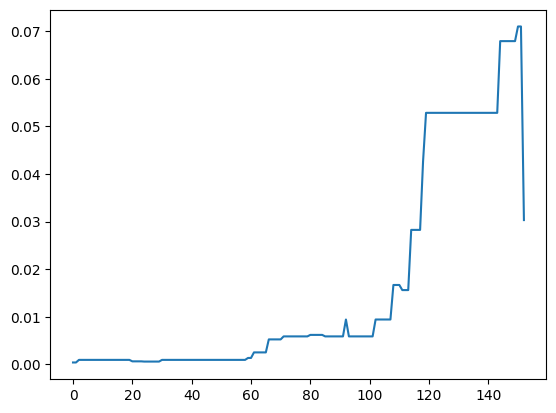

In [81]:
plt.plot(xt_overtime)

In [50]:

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

# detect pitch key points
result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

# project ball, players and referies on pitch

filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
pitch_reference_points = np.array(CONFIG_statsbomb.vertices)[filter]

# Here's where homography takes place (edit target to have statsbomb pitch measurements so that player xy and ball xy can be plotted using mplsoccer)
transformer = ViewTransformer(
    source=frame_reference_points,
    target=pitch_reference_points
)

frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_ball_xy = transformer.transform_points(points=frame_ball_xy)

xT_now(pitch_ball_xy, arsenal_xt)

0.0122571532

In [17]:
print(video_info)

VideoInfo(width=1280, height=720, fps=25, total_frames=390)


In [16]:
# plot players on 2D pitch
import supervision as sv
from sports.common.view import ViewTransformer
from sports.annotators.soccer import (
    draw_pitch,
    draw_points_on_pitch
)

TARGET_VIDEO_PATH = 'data/ozil_goal_cut_2d.mp4'

# SOURCE_VIDEO_PATH = "/content/ozil_goal_cut.mp4"
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=20, height=17
)

tracker = sv.ByteTrack()
tracker.reset()

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH) # info on the video
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info(width=1280, height=720, fps=25, total_frames=390)) # allows saving video to the hard drive

print(video_info)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)
with video_sink:
    # ball, goalkeeper, player, referee detection
    i=0
    for frame in tqdm(frame_generator, total=video_info.total_frames):
        result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
        detections = sv.Detections.from_inference(result)

        ball_detections = detections[detections.class_id == BALL_ID]
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

        all_detections = detections[detections.class_id != BALL_ID]
        all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
        all_detections = tracker.update_with_detections(detections=all_detections)

        goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
        players_detections = all_detections[all_detections.class_id == PLAYER_ID]
        referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

        # team assignment

        players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
        players_detections.class_id = team_classifier.predict(players_crops)

        goalkeepers_detections.class_id = resolve_goalkeepers_team_id(
            players_detections, goalkeepers_detections)

        referees_detections.class_id -= 1

        all_detections = sv.Detections.merge([
            players_detections, goalkeepers_detections, referees_detections])

        # frame visualization

        labels = [
            f"#{tracker_id}"
            for tracker_id
            in all_detections.tracker_id
        ]

        all_detections.class_id = all_detections.class_id.astype(int)

        # annotated_frame = frame.copy()
        # annotated_frame = ellipse_annotator.annotate(
        #     scene=annotated_frame,
        #     detections=all_detections)
        # annotated_frame = label_annotator.annotate(
        #     scene=annotated_frame,
        #     detections=all_detections,
        #     labels=labels)
        # annotated_frame = triangle_annotator.annotate(
        #     scene=annotated_frame,
        #     detections=ball_detections)

        # sv.plot_image(annotated_frame)

        players_detections = sv.Detections.merge([
            players_detections, goalkeepers_detections
        ])

        # detect pitch key points

        result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
        key_points = sv.KeyPoints.from_inference(result)

        # project ball, players and referies on pitch

        filter = key_points.confidence[0] > 0.5
        frame_reference_points = key_points.xy[0][filter]
        pitch_reference_points = np.array(CONFIG_statsbomb.vertices)[filter]

        transformer = ViewTransformer(
            source=frame_reference_points,
            target=pitch_reference_points
        )

        frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        pitch_ball_xy = transformer.transform_points(points=frame_ball_xy)

        players_xy = players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        pitch_players_xy = transformer.transform_points(points=players_xy)

        referees_xy = referees_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        pitch_referees_xy = transformer.transform_points(points=referees_xy)

        # visualize video game-style radar view

        annotated_frame = draw_pitch(CONFIG_statsbomb)
        annotated_frame = draw_points_on_pitch(
            config=CONFIG_statsbomb,
            xy=pitch_ball_xy,
            face_color=sv.Color.WHITE,
            edge_color=sv.Color.BLACK,
            radius=10,
            pitch=annotated_frame)
        annotated_frame = draw_points_on_pitch(
            config=CONFIG_statsbomb,
            xy=pitch_players_xy[players_detections.class_id == 0],
            face_color=sv.Color.from_hex('00BFFF'),
            edge_color=sv.Color.BLACK,
            radius=16,
            pitch=annotated_frame)
        annotated_frame = draw_points_on_pitch(
            config=CONFIG_statsbomb,
            xy=pitch_players_xy[players_detections.class_id == 1],
            face_color=sv.Color.from_hex('FF1493'),
            edge_color=sv.Color.BLACK,
            radius=16,
            pitch=annotated_frame)
        annotated_frame = draw_points_on_pitch(
            config=CONFIG_statsbomb,
            xy=pitch_referees_xy,
            face_color=sv.Color.from_hex('FFD700'),
            edge_color=sv.Color.BLACK,
            radius=16,
            pitch=annotated_frame)

        # sv.plot_image(annotated_frame)
        video_sink.write_frame(annotated_frame)
        i+=1
        if i==10:
            break

  0%|          | 0/390 [00:00<?, ?it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:04,  4.41s/it]


ball:  [[4278.866  1490.4436]
 [5079.024  2735.1714]]
players:  [[ 218.5  327. ]
 [ 631.   196. ]
 [1205.5  444. ]
 [ 794.5  321. ]
 [ 618.5  370. ]
 [1260.5  276. ]
 [ 315.5  579. ]
 [ 539.   239. ]
 [ 561.   225. ]]
refs:  [[ 760.5  361. ]
 [1179.   186. ]
 [ 553.   161. ]]


  0%|          | 1/390 [00:11<1:16:48, 11.85s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:04,  4.35s/it]


ball:  [[4350.8403 1667.8252]]
players:  [[ 224.5  327. ]
 [1213.5  443. ]
 [ 546.   238. ]
 [ 796.5  321. ]
 [ 639.   196. ]
 [ 627.   369. ]
 [ 323.   578. ]
 [1264.5  276. ]
 [ 571.   232. ]]
refs:  [[ 770.5  360. ]
 [1186.5  186. ]
 [ 558.   162. ]]


  1%|          | 2/390 [00:23<1:15:10, 11.63s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:04,  4.56s/it]


ball:  [[4430.4087 1893.9819]]
players:  [[1220.5  443. ]
 [ 231.   326. ]
 [ 645.5  195. ]
 [ 797.5  317. ]
 [ 551.   239. ]
 [ 634.   369. ]
 [ 328.   576. ]
 [1265.   275. ]
 [ 580.   223. ]]
refs:  [[ 780.5  356. ]
 [ 561.   162. ]
 [1191.   185. ]]


  1%|          | 3/390 [00:34<1:15:04, 11.64s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:04,  4.57s/it]


ball:  [[4376.048  1976.0757]]
players:  [[1226.   443. ]
 [ 553.   237. ]
 [ 236.   326. ]
 [ 650.   194. ]
 [ 643.5  368. ]
 [1265.   275. ]
 [ 331.5  576. ]
 [ 589.   225. ]
 [ 799.   297. ]]
refs:  [[ 788.   356. ]
 [ 564.5  161. ]
 [1193.   184. ]]


  1%|          | 4/390 [00:46<1:14:20, 11.56s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:04,  4.38s/it]


ball:  [[4426.7954 2174.922 ]]
players:  [[ 240.5  325. ]
 [ 554.   237. ]
 [1229.   443. ]
 [ 654.   192. ]
 [ 650.   367. ]
 [1266.5  274. ]
 [ 333.5  576. ]
 [ 797.   308. ]
 [ 596.   225. ]]
refs:  [[ 566.5  161. ]
 [ 795.   354. ]
 [1196.   184. ]]


  1%|▏         | 5/390 [00:57<1:13:48, 11.50s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:03,  3.94s/it]


ball:  [[4497.485  2369.7673]]
players:  [[ 556.   237. ]
 [ 242.   324. ]
 [1266.   273. ]
 [ 335.5  574. ]
 [ 656.5  192. ]
 [ 658.   363. ]
 [1230.   442. ]
 [ 795.   307. ]]
refs:  [[ 803.5  351. ]
 [ 601.5  224. ]
 [1198.   187. ]
 [ 568.5  160. ]]


  2%|▏         | 6/390 [01:09<1:13:30, 11.48s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:04,  4.61s/it]


ball:  [[4563.06  2547.895]]
players:  [[ 557.5  236. ]
 [1264.5  272. ]
 [ 242.5  323. ]
 [ 337.   574. ]
 [ 658.5  191. ]
 [1230.5  441. ]
 [ 791.   312. ]
 [ 664.   360. ]
 [ 570.5  160. ]]
refs:  [[ 810.5  351. ]
 [ 607.   224. ]
 [1199.   190. ]]


  2%|▏         | 7/390 [01:21<1:13:57, 11.58s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:03,  3.91s/it]


ball:  [[4677.064  2695.1475]]
players:  [[ 557.5  237. ]
 [1259.5  273. ]
 [ 789.5  313. ]
 [ 338.   573. ]
 [ 661.   190. ]
 [ 670.5  360. ]
 [ 240.   322. ]
 [1227.5  441. ]]
refs:  [[ 816.5  349. ]
 [1200.   187. ]
 [ 612.   225. ]
 [ 572.   159. ]]


  2%|▏         | 8/390 [01:31<1:11:57, 11.30s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:03,  3.52s/it]


ball:  [[4682.1826 2657.1267]]
players:  [[ 555.5  236. ]
 [ 788.5  313. ]
 [1257.5  273. ]
 [ 662.5  190. ]
 [ 339.5  572. ]
 [ 236.5  321. ]
 [ 672.5  359. ]]
refs:  [[ 819.5  349. ]
 [ 617.   225. ]
 [1201.   187. ]
 [ 571.5  158. ]]


  2%|▏         | 9/390 [01:42<1:10:08, 11.04s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:02,  2.89s/it]


ball:  [[4658.9224 2545.9153]]
players:  [[ 552.5  236. ]
 [ 786.   312. ]
 [ 663.5  189. ]
 [1256.5  274. ]
 [ 339.5  570. ]
 [ 678.5  356. ]]
refs:  [[ 823.   349. ]
 [ 572.5  158. ]
 [ 621.   224. ]
 [1201.5  183. ]]


  2%|▏         | 9/390 [01:52<1:19:18, 12.49s/it]
